In [32]:
from diffusers import DDPMPipeline
from torchvision import transforms, datasets
from torchvision.models import inception_v3
import torch
import numpy as np
from scipy.linalg import sqrtm
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm

In [27]:
DATASET_DIR = r"D:\data0\lsun\bedroom"
MODEL_ID = "google/ddpm-bedroom-256"
DATASET_SUBSET = 0.05

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
ddpm = DDPMPipeline.from_pretrained(MODEL_ID)
res = ddpm()
generated_images = res.images

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

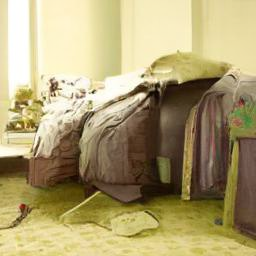

In [14]:
generated_images[0]

In [39]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize to 299x299 for Inception
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(root=DATASET_DIR, transform=transform)

total_len = len(dataset)
final_subset_indices = np.random.choice(total_len, int(DATASET_SUBSET * total_len), replace=False)

subset_dataset = Subset(dataset, final_subset_indices)
dataloader = DataLoader(subset_dataset, batch_size=32, shuffle=True)

In [ ]:
def get_features(dataloader, model, device):
    model = model.to(device)
    features = []
    with torch.no_grad():
        for images, _ in tqdm(dataloader, desc="Extracting features"):
            images = images.to(device)
            outputs = model(images)
            features.append(outputs.cpu().numpy())
    features = np.concatenate(features, axis=0)
    return features

In [ ]:
inception = inception_v3(pretrained=True, transform_input=False).eval()

In [ ]:
real_features = get_features(dataloader, inception, device)

In [ ]:
generated_image = generated_images[0]
generated_image = generated_image.resize((299, 299))
generated_image = transform(generated_image).unsqueeze(0).to(device)

with torch.no_grad():
    generated_features = inception(generated_image).cpu().numpy()

In [ ]:
mu_real = np.mean(real_features, axis=0)
sigma_real = np.cov(real_features, rowvar=False)

mu_gen = np.mean(generated_features, axis=0)
sigma_gen = np.cov(generated_features, rowvar=False)

def calculate_fid(mu1, sigma1, mu2, sigma2):
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

fid_score = calculate_fid(mu_real, sigma_real, mu_gen, sigma_gen)
print('FID score:', fid_score)